In [1]:
# pip install tqdm

# Load the libraries

In [4]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import PIL
from PIL import Image

import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from pathlib import Path

from tqdm import tqdm
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import random
import gc
import cv2

import tensorflow as tf
# tf.get_logger().setLevel('ERROR')
# tf.autograph.set_verbosity(2)
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## Preparing the Dataset and Setting Parameters

In [5]:
seed = 143
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.random.set_seed(seed)

In [11]:
data_dir = './raw/'
save_dir = './savefiles/'
size = 64
epochs = 5
val_split = 0.25

batch_size = 32

data_path = Path(data_dir)
images = sorted(list(map(str, list(data_path.glob("*/*.jpg")))))
labels = set([img.split(os.path.sep)[-2] for img in images])
num_labels = len(labels)

steps_per_epoch = len(images) * (1 - val_split) / batch_size
validation_steps = len(images) * val_split / batch_size

print("Number of images found: ", len(images))
print("Number of labels found: ", num_labels)
print("Labels:", sorted(labels))

Number of images found:  38398
Number of labels found:  19
Labels: ['a', 'ba', 'dara', 'ei', 'ga', 'ha', 'ka', 'kuw', 'la', 'ma', 'na', 'nga', 'ou', 'pa', 'sa', 'ta', 'tul', 'wa', 'ya']


In [12]:
# Augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=val_split,
                                   preprocessing_function=None,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.3],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.7,
                                   horizontal_flip=False,
                                   vertical_flip=False,)

val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=val_split)


# Load data and turn into batches
train_data = train_datagen.flow_from_directory(data_dir,
                                               subset="training",
                                               target_size=(size, size),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               seed=seed)

val_data = val_datagen.flow_from_directory(data_dir,
                                           subset="validation",
                                           target_size=(size, size),
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           seed=seed)

Found 28806 images belonging to 19 classes.
Found 9592 images belonging to 19 classes.


In [13]:
# For Keras Models (VGG16, Inception)

keras_train_datagen = ImageDataGenerator(validation_split=val_split,
                                   preprocessing_function=None,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7, 1.3],
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.7,
                                   horizontal_flip=False,
                                   vertical_flip=False,)

keras_val_datagen = ImageDataGenerator(validation_split=val_split)


# Load data and turn into batches
keras_train_data = keras_train_datagen.flow_from_directory(data_dir,
                                               subset="training",
                                               target_size=(size, size),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               seed=seed)

keras_val_data = keras_val_datagen.flow_from_directory(data_dir,
                                           subset="validation",
                                           target_size=(size, size),
                                           batch_size=batch_size,
                                           class_mode="categorical",
                                           seed=seed)

Found 28806 images belonging to 19 classes.
Found 9592 images belonging to 19 classes.


# CNN

In [14]:
tf.keras.backend.clear_session()
gc.collect()

65

In [16]:
base_cnn = models.Sequential()

base_cnn.add(layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same',
                 input_shape=(size, size, 3)))
base_cnn.add(layers.BatchNormalization(axis=3))
base_cnn.add(layers.Activation('relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

base_cnn.add(layers.Conv2D(filters=4, kernel_size=3, strides=1, padding='same',
                        activation='relu'))
base_cnn.add(layers.MaxPooling2D(pool_size=(3, 3)))

base_cnn.add(layers.Flatten())
base_cnn.add(layers.Dense(32, activation="relu"))
base_cnn.add(layers.Dropout(0.6))

base_cnn.add(layers.Dense(num_labels, activation='softmax'))
base_cnn.summary()


base_cnn.compile(loss='categorical_crossentropy',
                 optimizer=optimizers.Adam(learning_rate=0.001),
                 metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 64, 64, 4)         112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 4)         16        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 4)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 4)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)              

In [19]:
%%time

filepath_cnn = save_dir + "/testcnn.hdf5"
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=2, min_lr=0.00001, verbose=1)
earlystop_cnn = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

epochs = 2

base_cnn_history = base_cnn.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=val_data,
    callbacks=[checkpoint_cnn, reduce_lr_cnn, earlystop_cnn]
)

Epoch 1/2
899/899 [==============================] - 1484s 2s/step - loss: 2.3790 - accuracy: 0.2398 - val_loss: 1.1834 - val_accuracy: 0.7238

Epoch 00001: val_accuracy improved from -inf to 0.72383, saving model to ./savefiles/testcnn.hdf5
Epoch 2/2
899/899 [==============================] - 117s 129ms/step - loss: 1.9681 - accuracy: 0.3579 - val_loss: 0.8943 - val_accuracy: 0.7907

Epoch 00002: val_accuracy improved from 0.72383 to 0.79066, saving model to ./savefiles/testcnn.hdf5
CPU times: user 3min 53s, sys: 20.9 s, total: 4min 14s
Wall time: 26min 41s


In [20]:
def plot_results(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

    # plot accuracy 
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    ax1.plot(epochs, acc, 'ko', label='Training acc')
    ax1.plot(epochs, val_acc, 'k', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.legend()

    # plot loss
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    ax2.plot(epochs, loss, 'ro', label='Training loss')
    ax2.plot(epochs, val_loss, 'r', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epochs')
    ax2.legend()

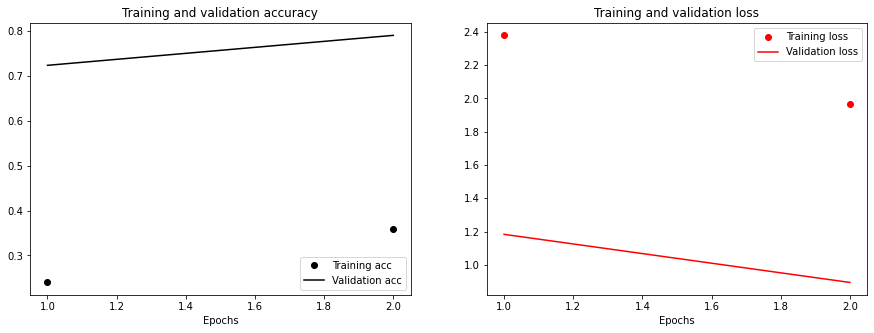

In [21]:
plot_results(base_cnn_history)

In [25]:
# save to pickle file
import joblib

joblib.dump('testcnn.pkl')

TypeError: dump() missing 1 required positional argument: 'filename'

In [3]:
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [29]:
path = ('/mnt/processed/private/msds2022/cpt11/ML3/'
        'Baybayin-Handwritten-Character-Dataset/raw/a/')
img_a = 'a_00001_file001.jpg'
img_ba = 'ba_00002_file001.jpg'

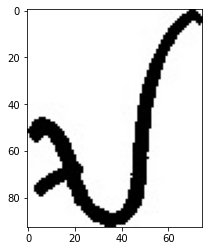

In [30]:
sample_a = cv2.imread(path+img_a)
plt.imshow(sample_a)

In [ ]:
import cv2

width = 640
height = 480

cap = cv2.VideoCapture(1)

width = 640
height = 480
cap.set(3, width)
cap.set(4, height)

pickle_in = open('cnn_sample.p', 'rb')
model = pickle.load(pickle_in)

In [ ]:
while True:
    success, imgOriginal = cap.read()
    img = np.asarray(imgOriginal)
    img = cv2.resize(img(32, 32))
    img = preProcessing(img)
    img = img.reshape(1,32,32,1)
    
    #predict
    classIndex = model.predict_classes(img)
    predictions = model.predict(img)
    probVal = np.amax(predictions)
    print(classIndex, probVal)
    
    threshold = 0.60

    if probVal > threshold:
        cv2.putText(imgOriginal, str(classIndex) + str(probVal),
                    (50,50), cv2.FONT_HERSHEY_COMPLEX, 1,
                    (0,0,255), 1)
    
    cv2.imshow('Original Image', imgOriginal)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

In [26]:
pwd

'/mnt/processed/private/msds2022/cpt11/ML3/Baybayin-Handwritten-Character-Dataset'

In [30]:
checkpoint_path = "./savefiles/base_cnn_wts.hdf5"


In [31]:
model = models.load_model('./savefiles/base_cnn.h5')


In [37]:
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_dir

'./savefiles'

In [39]:
model.load_weights(checkpoint_path)


In [ ]:
import cv2
import numpy as np
from PIL import Image
from keras import models
import os
import tensorflow as tf

checkpoint_dir = os.path.dirname(checkpoint_path)

model = models.load_model('./savefiles/base_cnn.h5')
model.load_weights(checkpoint_path)
video = cv2.VideoCapture(1)

In [50]:
!-ltrh /dev/video*



/bin/bash: - : invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--pretty-print
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [54]:


while True:
        _, frame = video.read()

        #Convert the captured frame into RGB
        im = Image.fromarray(frame, 'RGB')

        #Resizing into dimensions you used while training
        im = im.resize((109,82))
        img_array = np.array(im)

        #Expand dimensions to match the 4D Tensor shape.
        img_array = np.expand_dims(img_array, axis=0)

        #Calling the predict function using keras
        prediction = model.predict(img_array)#[0][0]
        print(prediction)
        #Customize this part to your liking...
#         if(prediction == 1 or prediction == 0):
#             print("No Human")
#         elif(prediction < 0.5 and prediction != 0):
#             print("Female")
#         elif(prediction > 0.5 and prediction != 1):
#             print("Male")

        cv2.imshow("Prediction", frame)
        key=cv2.waitKey(1)
        if key == ord('q'):
                break
video.release()
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute '__array_interface__'